<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [44]:
import numpy as np
import pandas as pd
import torch

from transformers import (
    BertModel,
    BertTokenizer,
    DistilBertModel,
    DistilBertTokenizer
)
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score
)

import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
tqdm.pandas()

from joblib import Parallel, delayed

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import gc
import math

import os.path


from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import NearMiss 


from pymystem3 import Mystem
import re


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [45]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    gc.collect()
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070


In [46]:
df = pd.read_csv('datasets/toxic_comments.csv', index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [62]:
df = df.sample(10000, random_state=12345)

In [63]:
def clear_text(text, re):
    return " ".join(re.sub(r"[^a-zA-Z ']", ' ', text).split()).lower()
    
# lemmatize(clear_text(df['text'].iloc[0], re=re))

df['text'] = df['text'].progress_apply(clear_text, re=re)

display(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [50]:
word_len = df['text'].str.split().str.len()

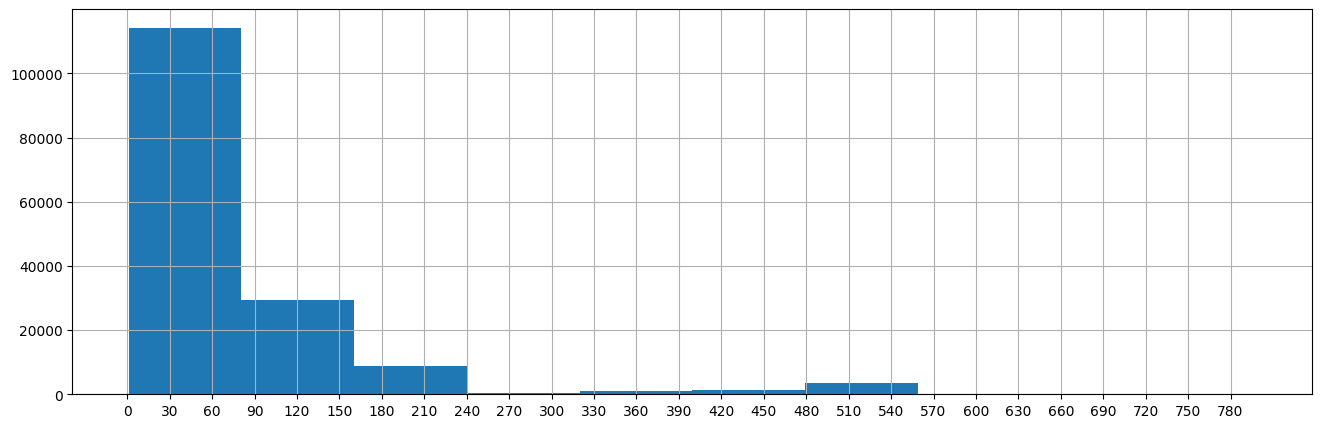

In [61]:
fig, ax = plt.subplots(figsize=(16,5))
plt.hist(word_len[word_len])
plt.grid()
plt.xticks(range(0, 800, 30))
plt.show()
None

Судя по графику в большинстве текстов не более 240 слов. Установим максимальную длину предложений в tokenizer-е

In [7]:
CACHE_FEATURES = False
FEATURES_PATH = 'features.csv'
MAX_LENGTH = 256

In [30]:
def get_bert(device):
    model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, 'bert-base-uncased')
    # model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    model.cuda(device)

    return model, tokenizer

def tokenize(text, tokenizer, max_length):
    return tokenizer.encode(
        text, 
        truncation=True, 
        max_length=max_length, 
        add_special_tokens=True
    )

# tokenize(df['text'].iloc[0], tokenizer)
# df['text'].apply(tokenize, tokenizer=tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


109583    [101, 6739, 4937, 20265, 25709, 2869, 2339, 20...
105077                   [101, 5005, 2521, 2102, 2831, 102]
82244     [101, 2019, 25617, 3796, 2003, 6413, 2130, 200...
18740     [101, 1045, 2123, 1005, 1056, 3305, 2339, 2057...
128310    [101, 7592, 2070, 1997, 1996, 2111, 3182, 2030...
                                ...                        
103202    [101, 2019, 3720, 2029, 2017, 2318, 2030, 6022...
151393    [101, 3931, 2011, 1996, 2203, 1997, 2088, 2162...
115288    [101, 2025, 2000, 2022, 6404, 2045, 2024, 2116...
55223     [101, 5432, 16948, 2003, 2025, 1037, 2208, 285...
82845     [101, 7570, 14510, 2186, 3494, 7632, 2045, 104...
Name: text, Length: 10000, dtype: object

In [9]:
def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    padded = torch.LongTensor(padded)  
    attention_mask = torch.LongTensor(attention_mask)

    return padded, attention_mask

In [10]:
def get_features(model, padded, attention_mask, batch_size = 100):
    embeddings = []
    for i in tqdm(range(math.ceil(padded.shape[0] / batch_size))):
        padded_batch = padded[batch_size*i:batch_size*(i+1)].to(device)
        attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)].to(device)
        
        with torch.no_grad():
            batch_embeddings = model(padded_batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    return np.concatenate(embeddings)

In [11]:
model, tokenizer = get_bert(device)

if CACHE_FEATURES & os.path.isfile(FEATURES_PATH):
    features = np.loadtxt(FEATURES_PATH, delimiter=',')

    print('[Info] Features loaded from local cache')
else:
    tokenized = df['text'].parallel_apply(lokenize, tokenizer=tokenizer, max_length=MAX_LENGTH)

    padded, attention_mask = get_padded_mask(tokenized)

    features = get_features(model, padded, attention_mask)

    if CACHE_FEATURES:
        np.savetxt(FEATURES_PATH, features, delimiter=',')
        print('[Info] Features saved to local cache')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Вывод:
Подготовлены данные для обучения, созданы embedding и релизовано сохранение, чтобы не ждать их формирования в дальнейшем.
Загружена предобучнная модель Bert, использован GPU.
Чтобы ускорить токенизацию использован pandarallel для параллельной работы.


## Обучение

In [ ]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(8,5))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [ ]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        # n_candidates="exhaust",
        # factor=5,
        n_jobs=-1,
        verbose=2
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_, hrs.best_params_, hrs.best_score_

С использованием NearMiss из-за разбалансированности классов

In [ ]:
labels = df['toxic']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.5, random_state=12345)

# nm = NearMiss()
# train_features, train_labels = nm.fit_resample(train_features, train_labels)

In [ ]:
lr_pipe = Pipeline([
    ('clf', LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced'))
])

param_grid = {
    'clf__solver' : ['liblinear'],
    'clf__max_iter' : [1000, 2500]
}

lr_estimator, lr_best_params, lr_best_score = search_best_estimator(lr_pipe, param_grid, train_features, train_labels)

print('F1 cv', lr_best_score)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
F1 cv 0.5556010556010557


In [ ]:
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=19, random_state=12345))
])
param_grid = {
    "clf__n_estimators": [150], #[i for i in range(100,250,50)],
    "clf__max_depth": [20], #[i for i in range(10,30,10)], #[i for i in range(10,60,5)],
    "clf__min_samples_split":[2], #[i for i in range(2,4,2)],
    "clf__min_samples_leaf": [2],
}

rf_estimator, rf_best_params, rf_best_score = search_best_estimator(rf_pipe, param_grid, train_features, train_labels)

print('F1 cv:', rf_best_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
F1 cv: 0.03508771929824561


In [ ]:
cb_pipe = Pipeline([
    ('clf', CatBoostClassifier(iterations=300, verbose=100))
])
param_grid = {
    "clf__learning_rate": [0.1] #[i/10 for i in range(1,3,1)] 
}

cb_estimator, cb_best_params, cb_best_score = search_best_estimator(cb_pipe, param_grid, train_features, train_labels)

print('F1 cv:', cb_best_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.6047539	total: 200ms	remaining: 59.9s
100:	learn: 0.0116382	total: 5.06s	remaining: 9.97s
200:	learn: 0.0032919	total: 9.82s	remaining: 4.83s
299:	learn: 0.0018503	total: 14.5s	remaining: 0us
F1 cv: 0.13032581453634084


In [ ]:
# tokenizer = transformers.BertTokenizer(vocab_file='datasets/ds_bert/vocab.txt')

# tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)

# padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
pipelines = pd.DataFrame(
    {
        "pipelines": [
            lr_pipe,
            rf_pipe,
            cb_pipe
        ],
        "scores": [lr_best_score, rf_best_score, cb_best_score]
    }
).sort_values(by='scores', ascending=False)
display(pipelines)
pipeline = pipelines.iloc[0]['pipelines']

,pipelines,scores
0,"(LogisticRegression(class_weight='balanced', r...",0.555601
2,(<catboost.core.CatBoostClassifier object at 0...,0.130326
1,"(RandomForestClassifier(max_depth=19, random_s...",0.035088


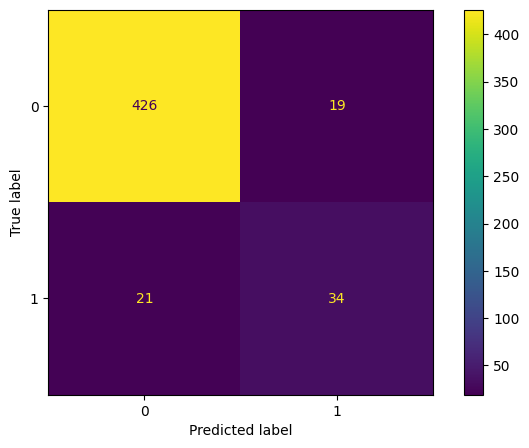

F1: 0.6296296296296297


In [ ]:
pipeline.fit(train_features, train_labels)

predictions = pipeline.predict(test_features)

plot_confusion_matrix(test_labels, predictions, pipeline)
print('F1:', f1_score(test_labels, predictions))

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны